In [1]:

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

    
    import os, glob
import sys
import json
import datetime
import numpy as np
import skimage.draw
import shutil
import tensorflow as tf
# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import visualize as vis
from mrcnn import model as modellib, utils
import matplotlib.pyplot as plt

############################################################
#  Configurations
############################################################

class GenericConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    def __init__(self, classes, steps):
        self.NUM_CLASSES = classes
        self.STEPS_PER_EPOCH = steps
        super().__init__()


    # Give the configuration a recognizable name
    NAME = "class"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.1
    IMAGE_MAX_DIM=448
    IMAGE_MIN_DIM=384
    TRAIN_ROIS_PER_IMAGE=20
    DETECTION_NMS_THRESHOLD=0.1
    DETECTION_MAX_INSTANCES=10
    #RPN_ANCHOR_SCALES = (32, 64, 128, 256)


############################################################
#  Dataset
############################################################

class GenericDataset(utils.Dataset):

    def load_item(self, dataset_dir, subset):
        """Load a subset of dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """


        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys


       # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        from PIL import Image
        # Add images
        classes = []

        # Find all images in the given dataset directory and load their annotations
        all_files = dict()
        for _ in os.listdir(dataset_dir):
            all_files[".".join(_.split(".")[:-1])] = _ 
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            polygons=[]
            objects=[]
            for r in a['regions']:
                polygons.append(r['shape_attributes'])
                objects.append(r['region_attributes'])

            class_ids = [int(n['class']) for n in objects]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            # print("multi_numbers=", multi_numbers)
            # num_ids = [n for n in multi_numbers['number'].values()]
            # for n in multi_numbers:
            image_path = dataset_dir + "/" + all_files[a['filename'] ]

            image = Image.open(image_path)
            width, height = image.size

            self.add_image(
                "class",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                class_ids=class_ids)

            for r in a['regions']:

                _class = r['region_attributes']['class']
                if _class not in classes:
                    classes += [_class]

        for i in range(2000):
            self.add_class("class", i+1,  str(_class))

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "class":
            return super(self.__class__, self).load_mask(image_id)
        class_ids = image_info['class_ids']
        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1



        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        #class_ids=np.array([self.class_names.index(shapes[0])])
        #print("info['class_ids']=", info['class_ids'])
        class_ids = np.array(class_ids, dtype=np.int32)
        return mask, class_ids#[mask.shape[-1]] #np.ones([mask.shape[-1]], dtype=np.int32)#class_ids.astype(np.int32)




In [2]:
"""Build Dataset."""
print("Loading Training Dataset...")
DATASET_DIR = "/media/sohaib/additional_/maskrcnn2_0/images/train/"

# Training dataset.
dataset_train = GenericDataset()
dataset_train.load_item(DATASET_DIR, "train")
dataset_train.prepare()

# Validation dataset
print("Loading Validation Dataset...")
dataset_val = GenericDataset()
dataset_val.load_item(DATASET_DIR, "val")
dataset_val.prepare()

Loading Training Dataset...
Loading Validation Dataset...


# Visualizing Dataset

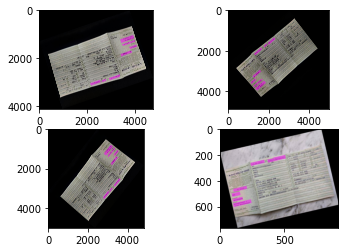

In [3]:
import random

count = 0
rows, cols      = 2, 2
class_ids = list(dataset_val.class_ids)
ids_list  = random.sample(class_ids[0:500], rows * cols)

for id_ in ids_list: 
    count += 1
    id_ -= 1
    
    image = dataset_val.load_image(id_)
    mask, class_id= dataset_val.load_mask(id_)
    _, _, masks_num = mask.shape
    # Ploting Masks
    for i in range(masks_num):
        mask_ = vis.apply_mask(image, mask[:,:,i], [1,2,3])
    
    plt.subplot(rows, cols, count)
    plt.imshow(mask_)
plt.show()

In [ ]:
from mrcnn.config import Config
WEIGHTS_DIR = "/media/sohaib/additional_/maskrcnn2_0/weights"



config = GenericConfig(2000, 100)

model = modellib.MaskRCNN(mode="training", config=config, model_dir=WEIGHTS_DIR)
                
# train(model, dataset_train, dataset_val, TOTAL_EPOCHS)


model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=10,
            layers='heads')

Initilizing Config

Starting at epoch 0. LR=0.001

Checkpoint Path: /media/sohaib/additional_/maskrcnn2_0/weights/448_class20210418T1434/mask_rcnn_448_class_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc     

In [ ]:
from tensorflow.python.client import device_lib

In [ ]:
local_device_protos = device_lib.list_local_devices()

In [ ]:
local_device_protos